<a href="https://colab.research.google.com/github/danielavargel/COLOR-NET/blob/master/final_daniel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D

In [ ]:
img_size = 100
snr = 10

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

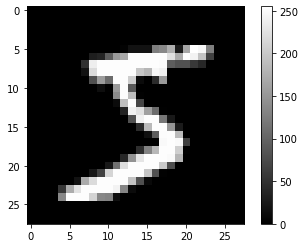

In [ ]:
plt.figure()
plt.imshow(x_train[0], cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

In [ ]:
def generate_image(data, labels, img_size, snr):
  # Create a uniform random noisy image:
  I = np.random.uniform(0, 255/snr, (img_size, img_size, 1))

  data_image_size = data.shape    # Total number of digits images

  # Toss random coordinates (row & column) for placing the digit image in the noisy image:
  r,c = np.random.randint(0, img_size - data_image_size[1], 2)

  # Toss random digit image to place in the noisy image:
  digit_ind = np.random.randint(0,data_image_size[0],1)

  # Add the random digit image to the noisy image in the random location:
  I[r:r+data_image_size[1], c:c+data_image_size[1],0] = I[r:r+data_image_size[1], c:c+data_image_size[1],0] + data[digit_ind]

  # Return the full image, the random coordinates and the digit class:
  return I, r + data_image_size[1] // 2, c + data_image_size[1] // 2, labels[digit_ind][0]

Text(0.5, 1.0, '3@(32,68)')

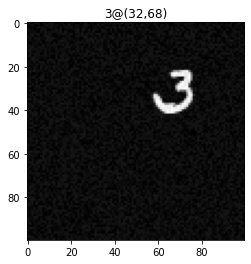

In [ ]:
I, r, c, l = generate_image(x_train, y_train, img_size, 10)
plt.imshow(I[:,:,0], cmap='gray')
plt.title(str(l) + "@(" + str(r) + "," + str(c) + ")")

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):

  def __init__(self, class_flag = 1, pos_flag = 1, batch_size=256, image_size=img_size, dim = (img_size,img_size) ,n_channels=1,snr = 10,db_size = 50000):
    self.batch_size = batch_size
    self.image_size = image_size
    self.db_size = db_size
    self.snr = snr
    self.dim = dim
    self.n_channels = n_channels
    self.data_image_size = [28,28]
    self.class_flag = class_flag
    self.pos_flag = pos_flag


  def __len__(self):
    return self.db_size//self.batch_size


  def __getitem__(self, index):

    x = np.empty((self.batch_size, self.image_size, self.image_size, 1))

    if self.class_flag == 1 and self.pos_flag == 1:
      y = np.zeros((self.batch_size, 12)) 
      digit_image_size = 28

      # Generate data
      for i in range(self.batch_size):
        I, r, c, l = generate_image(x_train, y_train, self.image_size, self.snr)
        r = r - digit_image_size // 2
        c = c - digit_image_size // 2
        x[i] = I / 255.0
        y[i,l] = 1           # One hot encoding of the class
        y[i,10:12] = [r / (self.image_size - digit_image_size),c / (self.image_size - digit_image_size)]   # Coordinates
      return x, y

    elif self.class_flag == 1: #class
        y = np.zeros((self.batch_size, 10)) 
        digit_image_size = 28
             
       # Generate data
        for i in range(self.batch_size):
          I, r, c, l = generate_image(x_train, y_train, self.image_size, self.snr)
          r = r - digit_image_size // 2
          c = c - digit_image_size // 2
          x[i] = I / 255.0
          y[i,l] = 1           # One hot encoding of the class
        return x, y

    elif self.pos_flag == 1: #class
        y = np.zeros((self.batch_size, 2)) 
        digit_image_size = 28
             
       # Generate data
        for i in range(self.batch_size):
          I, r, c, l = generate_image(x_train, y_train, self.image_size, self.snr)
          r = r - digit_image_size // 2
          c = c - digit_image_size // 2
          x[i] = I / 255.0
          y[0:2] = [r / (self.image_size - self.data_image_size[0]),c / (self.image_size - self.data_image_size[1])]   # Coordinates
        return x,y
    
    


(100, 100, 1)
[1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.04166667 0.54166667]


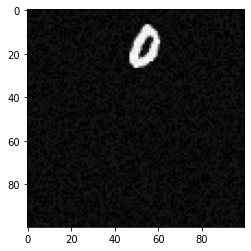

In [ ]:
class_training_generator = DataGenerator( 1,0, img_size)
pos_training_generator = DataGenerator( 0,1, img_size)
training_generator = DataGenerator(1,1, img_size) #all
x,y = training_generator.__getitem__(0)
ind = 0
x = x[ind]
y = y[ind]
print(x.shape)
plt.imshow(x[:,:,0], cmap='gray')
print(y)


(100, 100, 100, 1)
(100, 10)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


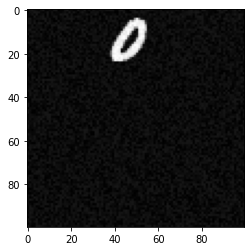

In [ ]:
x1,y1 = class_training_generator.__getitem__(2)
print(x1.shape)
print(y1.shape)
ind = 0
x1 = x1[ind]
y1 = y1[ind]
plt.imshow(x1[:,:,0], cmap='gray')
print(y1)


[0.54166667 0.84722222]


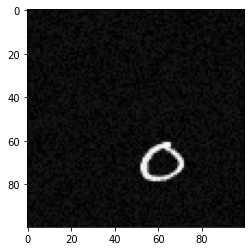

In [ ]:

x2,y2 = pos_training_generator.__getitem__(3000)
ind = 0
x2 = x2[ind]
y2 = y2[ind]
plt.imshow(x2[:,:,0], cmap='gray')
print(y2)

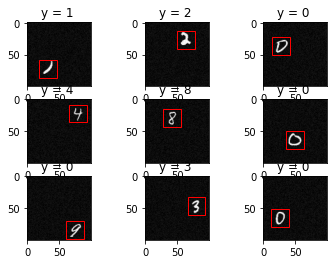

In [ ]:
# Unit test for 
for n in range(9):
  x,y = training_generator.__getitem__(n)
  ind = 0
  x = x[ind]
  y = y[ind]
  for i in range(9):
    if y[i] == 1:
      label = i

  ax = plt.subplot(3,3,n+1)
  plt.imshow(x[:,:,0], cmap='gray')
  norm =  training_generator.image_size - training_generator.data_image_size[0]

  #Create a Rectangle patch
  rect = patches.Rectangle((y[11] * norm , y[10] * norm), training_generator.data_image_size[1], training_generator.data_image_size[0], linewidth=1, edgecolor='r', facecolor='none')

  # Add the patch to the Axes
  ax.add_patch(rect)

  plt.title(f'y = {label} ')

In [ ]:
# Build neural network for training
input_shape0 =  (img_size,img_size,1)
model = tf.keras.Sequential()
model.net_name = 'mymodel'

model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape0))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:

model_pos = tf.keras.Sequential([model,
                                tf.keras.layers.Flatten(),
                                tf.keras.layers.Dense(512,activation='relu'),
                                tf.keras.layers.Dropout(0.3),
                                tf.keras.layers.Dense(2, activation='sigmoid')])


model_class.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_pos.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])

In [ ]:
history = model.fit_generator(generator=class_training_generator, epochs=5 , validation_data=class_training_generator)

history = model_pos.fit_generator(generator=pos_training_generator, epochs=5, validation_data=pos_training_generator)


Epoch 1/5
  1/500 [..............................] - ETA: 1:05 - loss: 2.3087 - accuracy: 0.1400

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


500/500 [==============================] - 53s 105ms/step - loss: 0.3257 - accuracy: 0.8937 - val_loss: 0.0913 - val_accuracy: 0.9724
Epoch 2/5
500/500 [==============================] - 52s 105ms/step - loss: 0.1491 - accuracy: 0.9555 - val_loss: 0.0667 - val_accuracy: 0.9789
Epoch 3/5
500/500 [==============================] - 52s 104ms/step - loss: 0.1314 - accuracy: 0.9605 - val_loss: 0.0748 - val_accuracy: 0.9786
Epoch 4/5
500/500 [==============================] - 52s 104ms/step - loss: 0.1148 - accuracy: 0.9649 - val_loss: 0.0603 - val_accuracy: 0.9817
Epoch 5/5
500/500 [==============================] - 52s 104ms/step - loss: 0.1071 - accuracy: 0.9673 - val_loss: 0.0522 - val_accuracy: 0.9843
Epoch 1/5
500/500 [==============================] - 54s 106ms/step - loss: 0.0159 - accuracy: 0.6471 - val_loss: 0.0064 - val_accuracy: 0.9895
Epoch 2/5
500/500 [==============================] - 52s 105ms/step - loss: 0.0064 - accuracy: 0.6293 - val_loss: 0.0066 - val_accuracy: 0.9900
Ep

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0.00885045 0.00905234]


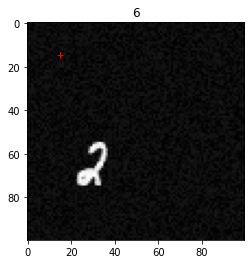

In [ ]:
def show_predictions(X, y, pred):
  plt.imshow(X[:,:,0], cmap='gray')
  plt.plot(pred[0], pred[1], 'r+')
  plt.title(str(pred[2]))

X,y = training_generator.__getitem__(5000)
pred_class = model.predict(X)
pred_pos = model_pos.predict(X)
ind = 0
X = X[ind]
y = y[ind]
pred_class = pred_class[ind]
print(pred_class)
pred_pos = pred_pos[ind]
print(pred_pos)
show_predictions(X,y, [pred_pos[1] * (img_size - 28) + 28 // 2, pred_pos[0] * (img_size - 28) + 28 // 2, np.argmax(pred_class[0:10])])